### Roomba movement simulation

#### Assumptions

1) Our robot is holonomic with two degrees of freedom. It can move forward and backward in the North-South axis or the East-West axis.

2) Our robot can only move one axis at the time. 

3) We represent the entirety of the room in which the robot operates as a grid. In any given time step the robot will move one tile in one axis, hence it can visit any of it's Von Neumann neighbors (it can not move diagonally in the grid). 

4) The robot will clean whatever tile in which it is currently located at every time step. Note that a more complex could choose not to clean it's current tile at some time step (which would correspond to saving energy or moving faster) which would allow for a more complex analysis of strategies




In [42]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.cm as cm
% matplotlib notebook
#%matplotlib inline 
import numpy as np
import random
from scipy import stats
from queue import PriorityQueue
from copy import deepcopy

In [72]:
class grid_map:
    def __init__(self, n = 10, obst_dens = 0.15, time = 0, dir_ind = None, 
                 sensor_std = 1,f_cost= None, g_cost = None, grid = None, pos = None):
        '''
        -n: room size (room is a square)
        -obst_dens: density of obstacles inside the room
        -time: time counter.
        - dir_ind: index to indicate robot direction (used in some strategies)
        -sensor_std: scale for sensor noise gaussian distribution 
        -f_cost and g_cost: are used in the A* search algorithm
        -grid: room configuration
        -pos: robot position
        '''       
        self.n = n
        self.obst_dens = obst_dens        
        self.time = 0
        self.dir_ind = dir_ind
        self.sensor_std = sensor_std
        self.dir_list = [[1,0],[0,1],[-1,0],[0,-1]]
        #pruned will be used for A* search
        self.pruned = False
        if not grid:
            self.grid = np.zeros(shape = (n,n))
            for i in range(n): 
                self.grid[0,i] = -100
                self.grid[i,0] = -100
                self.grid[n-1,i] = -100
                self.grid[i,n-1] = -100            
            self.random_obstacles()
        else: self.grid = grid            
        if not pos: self.place_robot()
        else: self.pos = pos              
    
    
    def random_obstacles(self):
        for i in range(1, self.n - 1):
            for j in range(1, self.n - 1):
                if random.random() < self.obst_dens and self.grid[i,j] == 0: self.grid[i,j] = -100
                    
          
    def place_robot(self, pos = None):
        if pos: self.pos = pos
        else:
            placed = False
            while not placed:
                i, j  = random.randint(1, self.n - 1), random.randint(1, self.n - 1)
                if self.grid[i,j] == 0: 
                    self.pos = [i,j]
                    placed = True
                                    
    
    def sensor_distance(self, pos = None, noise = True):
        #function to measure the distance from the robot to the neares wall/obstacle
        #We obtain distances in the 4 directions perpendicular to the robot's walls (cardinal directions)
        if not pos: pos = self.pos
        distances = []
        for dir_ind in range(4):
            this_dir = np.asarray(self.dir_list[dir_ind])
            dist = 1
            check_pos  = np.asarray(pos) + this_dir * dist
            while self.grid[check_pos[0], check_pos[1]] >= 0:
                dist += 1
                check_pos = np.asarray(pos) + this_dir * dist
            distances.append(dist)
        #Add noise
        if noise:
            for i in range(len(distances)):
                distances[i] += np.random.normal(scale = self.sensor_std)
        return distances
    
    def observe(self, X = None):
        plt.clf() 
        #Check if we are displaying particle filtering
        if X:
            #add some noice so particles don't overlap completely
            for i in range(len(X)):
                plt.scatter(X[i][1] + np.random.normal(0,0.15),
                            X[i][0] + np.random.normal(0,0.15), c='b') 
        plt.scatter(self.pos[1], self.pos[0], c='r')
        plt.title('timestep : %s'%self.time)
        plt.imshow(self.grid, cmap= cm.viridis, interpolation='none')
        plt.show()
        
    
    def particle_filtering(self, kinetic_func, X = None, W = None, D = None, particles = 200, steps = 1):
        #Initial sample:
        if not W: W = [1.0/particles for _ in range(particles)]
        if not D: D = [None for _ in range(particles)]
        if not X:         
            X = []
            for _ in range(particles):
                valid = False
                while not valid:
                    x, y = random.randint(0,self.n-1), random.randint(0,self.n-1)
                    if self.grid[x,y] >= 0:
                        valid = True
                        X.append([x,y])                
            return X, W, D
        
        for i in range(steps):

            #update points based on motion model  
            #if motion is not deterministic, we are basically sampling from P(X'|X) 
            for i in range(particles):
                X[i], D[i] = kinetic_func(self, dir_ind = D[i], pos = X[i], particle = True)
            #Move robot and obtain sensor measurements
            self.pos, self.dir_ind = kinetic_func(self)
            sensors = self.sensor_distance()            
            #Update  weights. w = P(Observed| Real)
            for i in range(particles):
                particle_distances = self.sensor_distance(pos = X[i], noise = False)
                w = 1                
                for j in range(4):
                    w *= stats.norm.pdf(sensors[j] , 
                                        loc = particle_distances[j], scale = self.sensor_std)
                W[i] = w
            N =  sum(W)
            W = [w/N for w in W]
            
            #sample points
            X_ind = np.random.choice([j for j in range(particles)], p= W, size = particles, replace = True)
            X_prime = [X[j] for j in X_ind]
                
        return X_prime, W, D      
            
    
    #Remove obstacles from array so we can measure performance
    def tiles(self):
        flat = np.ndarray.flatten(self.grid)
        out = []
        for tile in flat:
            if tile >= 0:
                out.append(tile)
        return np.asarray(out)                    

Now we define the strategies our robot may follow to move. It is convenient to have these strategies outside of our main class for two reasons: it allows us to test new strategies without modifying our main class, and it will allow us to include them as input for the particle filltering function (so we tell the function which strategy the robot is following, and we update our particles with the same strategy). 

In [70]:
def random_walk(Sim, dir_ind = None, pos = None, particle = False):
    #try random directions until we find a free one
    if not pos: pos = Sim.pos[:]
    moved = False
    while not moved:
        dir_ind = random.randint(0, len(Sim.dir_list) - 1)
        x, y = pos[0] + Sim.dir_list[dir_ind][0], pos[1] + Sim.dir_list[dir_ind][1]
        #check if free
        if Sim.grid[x,y] >= 0: 
            pos = [x,y]
            if not particle: Sim.grid[x,y] += 1
            if not particle: Sim.time += 1
            moved = True
    return pos, dir_ind        


def random_bounce(Sim, dir_ind = None, pos = None, particle = False):
    #Similar to random walk, but we first try to move in the same direction we moved before
    if not pos: pos = Sim.pos
    if not particle: dir_ind = Sim.dir_ind
    if not dir_ind: dir_ind = random.randint(0, len(Sim.dir_list) - 1)
    moved = False        
    while not moved:            
        x, y = pos[0] + Sim.dir_list[dir_ind][0], pos[1] + Sim.dir_list[dir_ind][1]
        #check if free
        if Sim.grid[x,y] >= 0: 
            pos = [x,y]
            if not particle: Sim.grid[x,y] += 1
            if not particle: Sim.time += 1
            moved = True
        #we want to keep the same direction unless we can't move there
        if not moved: dir_ind = random.randint(0, len(Sim.dir_list) - 1)
    if not particle: Sim.dir_ind = dir_ind
    return pos, dir_ind

In [31]:
#Gini coefficient calculating function taken from: https://github.com/oliviaguest/gini

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

##  Random Walk Strategy

We can run this animation to see the behaviour of our robot under a random walk strategy.

<IPython.core.display.Javascript object>


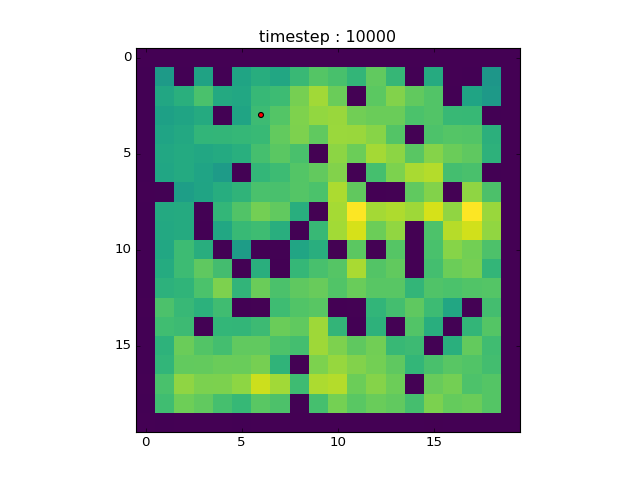

In [73]:
Sim = grid_map(n = 20, obst_dens = 0.15)
for i in range(10000):
    Sim.pos,_ = random_walk(Sim)
Sim.observe()

<IPython.core.display.Javascript object>


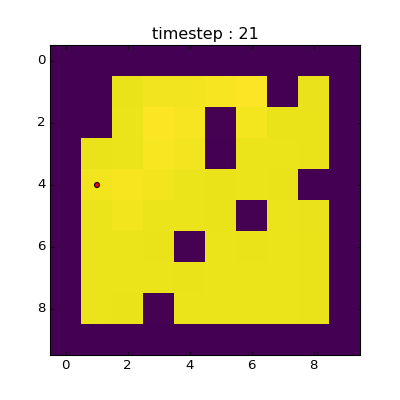

In [10]:
def animate(i):
    for t in  range(1):
        Sim.pos,_ = random_walk(Sim)
    return Sim.observe()
    
Sim = grid_map(obst_dens = 0.15)
fig = plt.figure(figsize = (5,5))  
ani = animation.FuncAnimation(fig, animate, frames= 100,
                    interval = 1000, blit= False, repeat = False)

#### Inequality after a fixed number of steps

In [5]:
gini_list = []
for i in range(100):
    Sim = grid_map(obst_dens = 0.15)
    direction = None
    for _ in range(1000):
         Sim.pos,_ = random_walk(Sim)
    gini_list.append(gini(Sim.tiles()))


<IPython.core.display.Javascript object>


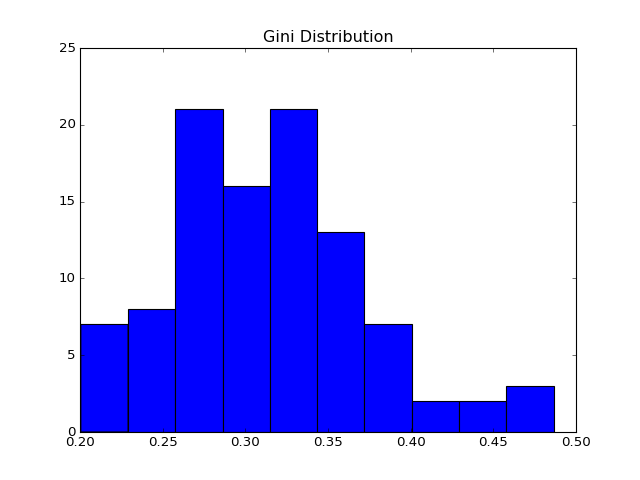

In [6]:
plt.hist(gini_list)
plt.title("Gini Distribution")
plt.show()

## Random Bounce Strategy

<IPython.core.display.Javascript object>


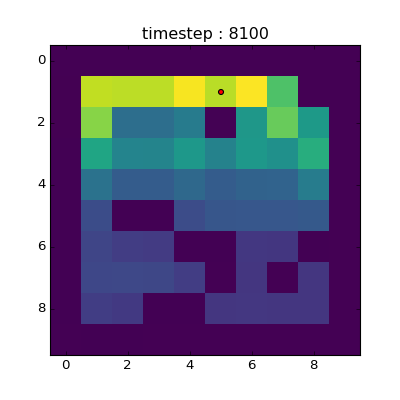

In [9]:
def animate(i):
    for t in  range(100):
        Sim.pos,_ = random_bounce(Sim)
    return Sim.observe()
    
Sim = grid_map(obst_dens = 0.15)
fig = plt.figure(figsize = (5,5))  
ani = animation.FuncAnimation(fig, animate, frames= 1000,
                    interval = 1, blit= True, repeat = False)

In [7]:
gini_list = []
for i in range(100):
    Sim = grid_map(obst_dens = 0.15)
    direction = None
    for _ in range(2000):
        Sim.pos,_ = random_bounce(Sim)
    gini_list.append(gini(Sim.tiles()))

<IPython.core.display.Javascript object>


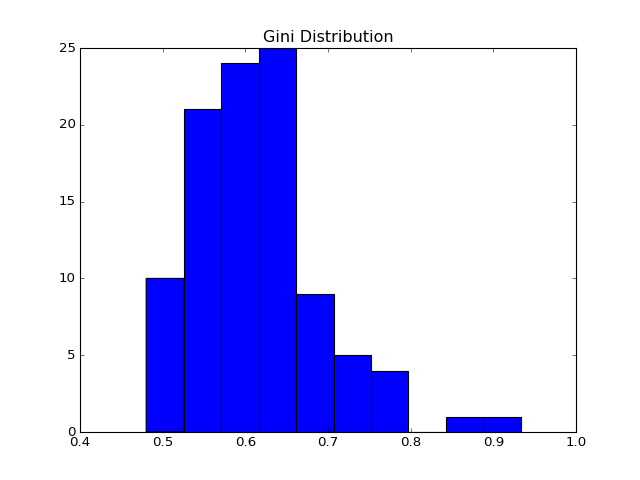

In [8]:
plt.hist(gini_list)
plt.title("Gini Distribution")
plt.show()

## Monte Carlo Localization

So far we have analized strategies that are map agnostic. Our robot decides were to move based on sensor information (for instance, whether there is an obstacle next of the robot in a given direction) without knowing the room's map or the robot's position in it. However, if the robot knew the map's layout and it's position in it, it could use a search algorithm to decide on the most optimal set of moves. For instance, we could use search to request for a state in which all tiles have been cleaned the same amount of times. Let us assume that our robot already knows the map, either because the user specified it or because the robot has previously followed a different routine to explore the whole map and identify obstacles. Let us see if the robot can succesfully use Monte Carlo Localization to find it's possition in the map.

#### Assumptions

1) The robot can measure the distance to the nearest obstacle/wall in the 4 directions perpendicular to the robot's sides (seen in the map as cardinal directions). 



<IPython.core.display.Javascript object>


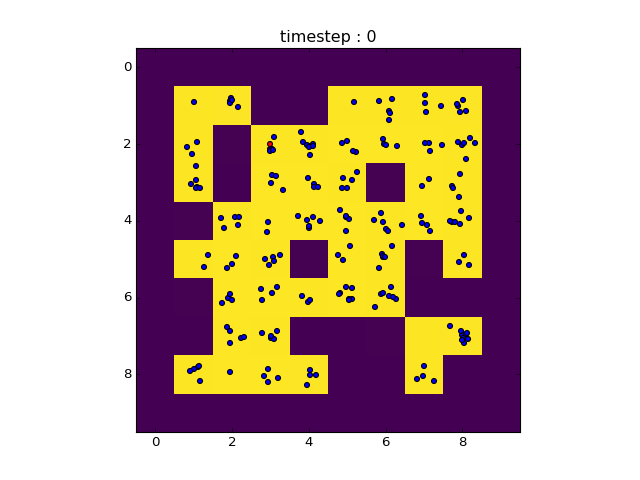

In [11]:
Sim = grid_map(n = 10, obst_dens = 0.20, sensor_std = 1 )
X, W, D = Sim.particle_filtering(random_walk)
Sim.observe(X = X)

<IPython.core.display.Javascript object>


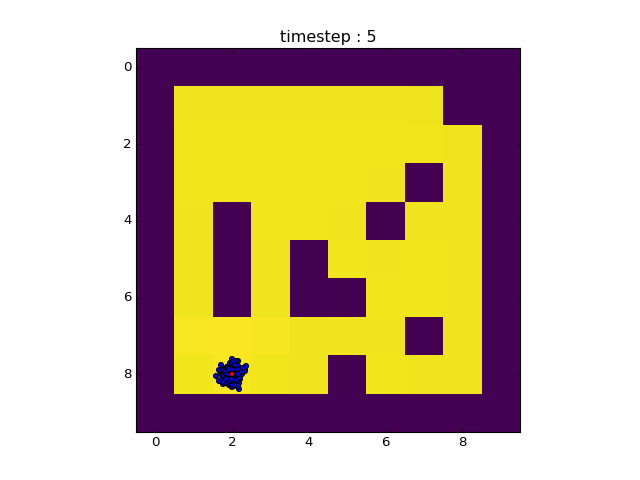

In [79]:
X, W, D = Sim.particle_filtering(random_walk, X = X, W = W, D = D, steps = 1)
Sim.observe(X = X)

In [ ]:
Sim = grid_map(n = 10, obst_dens = 0.15, sensor_std = 1)
X, W, D = Sim.particle_filtering(random_walk)

def animate(i):
    global X, W, D
    for t in range(1):
        X, W, D = Sim.particle_filtering(random_walk, X = X, W = W, D = D, steps = 1)
    print 'here'
    return Sim.observe(X = X)


fig = plt.figure(figsize = (5,5))  
ani = animation.FuncAnimation(fig, animate, frames= 100,
                    interval = 100, blit= True, repeat = True)

### Search based cleaning

We have now proven that we are capable of identifying the robot's position on the map after just a few time steps using our particle filtering algorithm. Hence, once the map (and the obstacle locations in it) is known, the robot can use a few time steps to find it's location in the map, and then it could calculate an optimal cleaning route using this information. Let us consider the effectiveness of such approach.

#### Assumptions

1) The robot knows the map, the locations of walls and obstacles and it's own location.

2) The robot will be turned on for a certain amount of timesteps. In each time step the robot will move to some direction (benefit of saving energy by not moving at some timestep is neglected).

3) The robot's goal is to have the floor be as evenly clean as possible. Hence, if the robot will be turned on for an amount of time T, and there are N tiles, a goal state would have each tile visited exactly T/N times.

4) We don't care about the robot's position at the end step. 

In [23]:
def Astar_search(Sim, T):
        
    goal = [[float(T/ (Sim.n**2)) for _ in range(Sim.n)] for _ in range(Sim.n)]

    # Dictionary with current cost to reach all visited nodes
    costs_db = {str(Sim.grid): Sim}
    
    frontier = PriorityQueue()
    frontier.put(start_node)
    
    # Begin A* Search
    expansion_counter = 0

    while not frontier.empty():
        # Get front of frontier (priority)
        current = frontier.get()

        if current.pruned:
            continue # Skip if this node has been marked for removal

        # Check if we are at the goal
        if current.gird == goal: break
        
        
        # Robot coordinates
        y_0, x_0 = Sim.pos

        # Check all 4 options for moving robot
        for dx, dy in [(-1, 0), (1,0), (0,1), (0,-1)]:

            if y_0 + dy in range(0, n) and x_0 + dx in range(0, n):
               
                #move robot in copy of state
                next_node = deepcopy(current)     
                if next_node.grid[y_0 + dy][x_0 + dx] >= 0:
                    next_node.place_robot([y_0 + dy, x_0 + dx])
                    next_node.grid[y_0 + dy][x_0 + dx] += 1                
                g = current.g_cost + 1 
                # If we explored same grid layout before
                if str(next_node.grid) in costs_db:
                    if costs_db[str(next_node.grid)].g > g:
                        # Previous path to node is worse
                        costs_db[str(next_state)].pruned = True 
                    else:
                        continue # New path is worse

                h = heuristic(next_state) 
                # Add best cost to new node and put it in frontier
                next_node = PuzzleNode(next_state, g+h, g, cur_node)
                frontier.put(next_node)
                costs_db[str(next_state)] = next_node 

        expansion_counter = expansion_counter + 1 # We finished expanding the node

    
    
    if output:
        # Reconstruct the optimal path using parent pointers
        optimal_path = [cur_node.state]
        while cur_node.parent:
            optimal_path.append((cur_node.parent).state)
            cur_node = cur_node.parent
        print("A* search completed in %d steps\n"% expansion_counter)
        print("Optimal Path to Goal:\n")
        for grid in optimal_path[::-1]:
            print(grid)
        print("Current frontier size: %d"%frontier.qsize())
    
    return expansion_counter, frontier.qsize(), 0

In [68]:
Sim1.grid[1,1] += 1
Sim1.grid


array([[-100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100.],
       [-100.,    2.,    0.,    0., -100.,    0.,    0.,    0.,    0.,
        -100.],
       [-100.,    0.,    0.,    0.,    0., -100.,    0.,    0.,    0.,
        -100.],
       [-100.,    0., -100., -100.,    0.,    0.,    0., -100.,    0.,
        -100.],
       [-100.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        -100.],
       [-100., -100.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        -100.],
       [-100.,    0., -100.,    0.,    0., -100.,    0.,    0.,    0.,
        -100.],
       [-100., -100.,    0., -100.,    0.,    0.,    0.,    0., -100.,
        -100.],
       [-100.,    0., -100.,    0.,    0.,    0.,    0.,    0.,    0.,
        -100.],
       [-100., -100., -100., -100., -100., -100., -100., -100., -100.,
        -100.]])